In [1]:
from typing import Literal, TypedDict

from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field

In [2]:
load_dotenv()

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")

In [3]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(
        description="Sentiment of the review"
    )


class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(
        description="The category of issue mentioned in the review"
    )
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(
        description="The emotional tone expressed by the user"
    )
    urgency: Literal["low", "medium", "high"] = Field(
        description="How urgent or critical the issue appears to be"
    )


structured_model_sentiment = model.with_structured_output(schema=SentimentSchema)
structured_model_diagnosis = model.with_structured_output(schema=DiagnosisSchema)

In [4]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]

    diagnosis: dict
    response: str

In [5]:
def find_sentiment(state: ReviewState) -> ReviewState:
    prompt = f"Find the sentiment of the Review - {state['review']}"
    sentiment = structured_model_sentiment.invoke(prompt).sentiment

    return {"sentiment": sentiment}


def check_sentiment(
    state: ReviewState,
) -> Literal["negative", "positive"]:
    return state["sentiment"]


def run_diagnosis(state: ReviewState) -> ReviewState:
    prompt = f"""
    Diagnose this negative review
    \n\n "{state['review']}" \n\n
    Return issue_type, tone, and urgency.
    """

    diagnosis = structured_model_diagnosis.invoke(prompt)

    return {"diagnosis": diagnosis.model_dump()}


def negative_response(state: ReviewState) -> ReviewState:
    diagnosis = state["diagnosis"]

    prompt = f"""
    You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message.
    """

    response = model.invoke(prompt).content

    return {"response": response}


def positive_response(state: ReviewState) -> ReviewState:
    prompt = f"""
    Write a warm thank-you message in response to this review:
    \n\n "{state['review']}" \n\n
    Also, kindly ask the user to leave feedback on our website
    """

    response = model.invoke(prompt).content

    return {"response": response}

In [6]:
graph = StateGraph(ReviewState)


graph.add_node("find_sentiment", find_sentiment)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_response", negative_response)
graph.add_node("positive_response", positive_response)


graph.add_edge(START, "find_sentiment")
graph.add_edge("run_diagnosis", "negative_response")

graph.add_conditional_edges(
    "find_sentiment",
    check_sentiment,
    {"negative": "run_diagnosis", "positive": "positive_response"},
)

graph.add_edge("negative_response", END)
graph.add_edge("positive_response", END)


workflow = graph.compile()

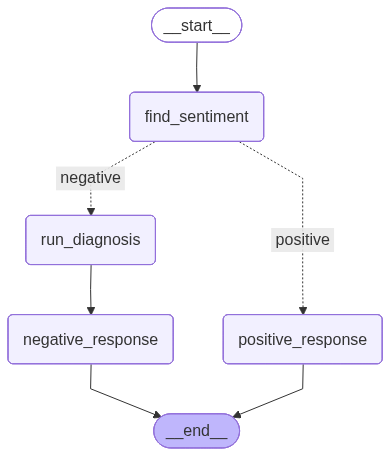

In [7]:
workflow

In [8]:
initial_state = {
    "review": "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}

final_state = workflow.invoke(initial_state)
final_state

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "I understand you're experiencing a bug and are feeling frustrated, especially with the high urgency of this issue. I'm really sorry to hear that this is causing you trouble.\n\nPlease know that we're taking this very seriously and are working diligently to resolve it for you as quickly as possible. To help us get to the bottom of this and implement a fix, could you please provide us with a few more details?\n\nSpecifically, if you could share:\n\n*   **A clear description of the bug:** What exactly is happening that shouldn't be?\n*   **Steps to reproduce the bug:** If possible, please outline the exact steps you take that lead t